In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import yfinance as yf
from datetime import time
sys.path.append(os.path.abspath("../src"))
from data_cleaner import DataCleanerConfig, DataCleaner, preprocess_data

# Para ir tocando data_cleaner sin tener que reiniciar el kernel
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
# Configuración para datos a 5m
cfg_5m = DataCleanerConfig(
    source="alpaca",
    symbol="QQQ",
    interval="5m",
    start_date="2022-01-01",
    end_date="2025-11-30",
   
)

cleaner = DataCleaner(cfg_5m)
df_raw = cleaner.cargar_datos()
df = preprocess_data(df_raw)

df

,symbol,datetime,open,high,low,close,volume,trade_count,vwap,volume_norm,return,log_return_raw,log_return_close,log_ret_oc,log_ret_hl,log_ret_ch,log_ret_cl
0,QQQ,2022-01-03 09:05:00+00:00,399.3900,399.40,399.2500,399.4000,7602.0,93.0,399.340687,-0.592960,0.000000e+00,5.989963,0.000000e+00,0.000025,0.000376,0.000000e+00,0.000376
1,QQQ,2022-01-03 09:10:00+00:00,399.3900,399.53,399.3800,399.5300,7260.0,53.0,399.424946,-0.593720,3.254882e-04,5.990289,3.254353e-04,0.000350,0.000376,0.000000e+00,0.000376
2,QQQ,2022-01-03 09:15:00+00:00,399.5400,399.56,399.3400,399.3500,6878.0,112.0,399.470116,-0.594568,-4.505294e-04,5.989838,-4.506309e-04,-0.000476,0.000551,-5.257163e-04,0.000025
3,QQQ,2022-01-03 09:20:00+00:00,399.3300,399.49,399.3000,399.4900,7998.0,48.0,399.398335,-0.592081,3.505697e-04,5.990189,3.505082e-04,0.000401,0.000476,0.000000e+00,0.000476
4,QQQ,2022-01-03 09:25:00+00:00,399.4800,399.48,399.4000,399.4000,1444.0,30.0,399.447894,-0.606631,-2.252872e-04,5.989963,-2.253126e-04,-0.000200,0.000200,-2.002804e-04,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185162,QQQ,2025-11-28 21:35:00+00:00,619.0400,619.09,619.0400,619.0800,608.0,28.0,619.082265,-0.608487,-3.230496e-05,6.428235,-3.230548e-05,0.000065,0.000081,-1.615287e-05,0.000065
185163,QQQ,2025-11-28 21:40:00+00:00,619.0497,619.08,619.0100,619.0796,3219.0,50.0,619.075416,-0.602690,-6.461200e-07,6.428234,-6.461203e-07,0.000048,0.000113,-6.461203e-07,0.000112
185164,QQQ,2025-11-28 21:45:00+00:00,619.0691,619.25,619.0691,619.2100,4562.0,87.0,619.147342,-0.599709,2.106353e-04,6.428444,2.106131e-04,0.000228,0.000292,-6.459635e-05,0.000228
185165,QQQ,2025-11-28 21:50:00+00:00,619.2000,619.23,619.1600,619.1700,1828.0,45.0,619.181573,-0.605778,-6.459844e-05,6.428380,-6.460053e-05,-0.000048,0.000113,-9.689922e-05,0.000016


In [69]:
df.columns

Index(['symbol', 'datetime', 'open', 'high', 'low', 'close', 'volume',
       'trade_count', 'vwap', 'volume_norm', 'return', 'log_return_raw',
       'log_return_close', 'log_ret_oc', 'log_ret_hl', 'log_ret_ch',
       'log_ret_cl'],
      dtype='object')

In [70]:
FEATURE_COLUMNS = [
    "open", "high", "low", "close",
    "volume", "trade_count", "vwap",
    "volume_norm",
    "return",
    "log_return_close",
    "log_ret_oc",
    "log_ret_hl",
    "log_ret_ch",
    "log_ret_cl"
]

HORIZON = 24  # 24 velas de 5m = 2 horas

df = df.copy()
df["target_2h"] = np.log(df["close"].shift(-HORIZON) / df["close"])


#Quitamos filas sin target
df = df.dropna().reset_index(drop=True)

In [71]:
HORIZON = 24
df["close_future"] = df["close"].shift(-HORIZON)

# dirección:
df["direction_2h"] = (df["close_future"] > df["close"]).astype(int)

df = df.dropna(subset=["direction_2h"]).reset_index(drop=True)


In [72]:
split_ts = pd.Timestamp("2025-11-01 00:00:00+00:00")

df_train = df[df["datetime"] <= split_ts].reset_index(drop=True)
df_test  = df[df["datetime"] >  split_ts].reset_index(drop=True)

print("Rango TRAIN :", df_train["datetime"].min(), "→", df_train["datetime"].max())
print("Rango TEST  :", df_test["datetime"].min(),  "→", df_test["datetime"].max())
print("Shapes      :", df_train.shape, df_test.shape)

Rango TRAIN : 2022-01-03 09:05:00+00:00 → 2025-10-31 23:55:00+00:00
Rango TEST  : 2025-11-03 09:00:00+00:00 → 2025-11-28 19:55:00+00:00
Shapes      : (181555, 20) (3588, 20)


In [73]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_raw = df_train[FEATURE_COLUMNS].values
X_test_raw  = df_test[FEATURE_COLUMNS].values

X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled  = scaler.transform(X_test_raw)

# Reconstruimos dataframes escalados
df_train_scaled = pd.DataFrame(X_train_scaled, columns=FEATURE_COLUMNS)
df_train_scaled["datetime"] = df_train["datetime"].values
df_train_scaled["direction_2h"] = df_train["direction_2h"].values

df_test_scaled = pd.DataFrame(X_test_scaled, columns=FEATURE_COLUMNS)
df_test_scaled["datetime"] = df_test["datetime"].values
df_test_scaled["direction_2h"] = df_test["direction_2h"].values

df_train_scaled["target_2h"] = df_train["target_2h"].values
df_test_scaled["target_2h"] = df_test["target_2h"].values



In [74]:
import torch
from torch.utils.data import Dataset, DataLoader

class SlidingWindowDataset(Dataset):
    def __init__(self, df, feature_cols, target_col="target_2h", seq_len=64):
        """
        df: dataframe escalado con columnas features + datetime + target_2h
        """
        self.seq_len = seq_len
        self.feature_cols = feature_cols
        
        # Convertimos a tensores para PyTorch
        self.features = torch.tensor(df[feature_cols].values, dtype=torch.float32)
        self.targets = torch.tensor(df[target_col].values, dtype=torch.float32)
        
        # Guardamos timestamps en formato string (por simplicidad)
        self.timestamps = df["datetime"].astype(str).values

    def __len__(self):
        return len(self.features) - self.seq_len

    def __getitem__(self, idx):
        # Secuencia de tamaño seq_len
        x = self.features[idx : idx + self.seq_len]

        # Target para horizon = seq_len + 24 (pero ya está hecho en target_2h)
        y = self.targets[idx + self.seq_len]

        # Timestamp del momento donde hacemos la predicción
        ts = self.timestamps[idx + self.seq_len]

        return x, y, ts


In [75]:
SEQ_LEN = 64  # ventana de observación (64 velas)

train_dataset = SlidingWindowDataset(
    df_train_scaled, 
    feature_cols=FEATURE_COLUMNS,
    target_col="target_2h",
    seq_len=SEQ_LEN
)

test_dataset = SlidingWindowDataset(
    df_test_scaled, 
    feature_cols=FEATURE_COLUMNS,
    target_col="target_2h",
    seq_len=SEQ_LEN
)

len(train_dataset), len(test_dataset)


(181491, 3524)

In [76]:
BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [77]:
# Ver un batch
xb, yb, tsb = next(iter(train_loader))

print("Batch X:", xb.shape)   # (batch, seq_len, num_features)
print("Batch y:", yb.shape)   # (batch,)
print("Timestamp example:", tsb[0])


Batch X: torch.Size([64, 64, 14])
Batch y: torch.Size([64])
Timestamp example: 2025-03-25 10:10:00


# Ahora la LSTM

In [78]:
import torch.nn as nn

class LSTMRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, dropout=0.2):
        super().__init__()

        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True
        )

        # LayerNorm ayuda MUCHO a la estabilidad del entrenamiento
        self.norm = nn.LayerNorm(hidden_dim)

        # Capa final para sacar la predicción del log-return
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        last_hidden = out[:, -1, :]      # último estado
        last_hidden = self.norm(last_hidden)
        out = self.fc(last_hidden)
        return out.squeeze(-1)


In [79]:
input_dim = len(FEATURE_COLUMNS)

model = LSTMRegressor(
    input_dim=input_dim,
    hidden_dim=64,
    num_layers=2,
    dropout=0.2
)

model


LSTMRegressor(
  (lstm): LSTM(14, 64, num_layers=2, batch_first=True, dropout=0.2)
  (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

## Configuramos el entrenamiento

In [80]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Pérdida: Huber (SmoothL1) suele ir mejor que MSE en finanzas
criterion = nn.SmoothL1Loss()

# Optimizador
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

In [81]:
def train_lstm(model, train_loader, test_loader, num_epochs=10):
    model.train()
    history = {"train_loss": [], "val_loss": []}

    for epoch in range(1, num_epochs + 1):
        # ---- TRAIN ----
        model.train()
        train_losses = []

        for xb, yb, _ in train_loader:      # ignoramos timestamp
            xb = xb.to(device)
            yb = yb.to(device)

            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()

            # prevención explosión de gradientes
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            train_losses.append(loss.item())

        # ---- VALID ----
        model.eval()
        val_losses = []
        with torch.no_grad():
            for xb, yb, _ in test_loader:
                xb = xb.to(device)
                yb = yb.to(device)
                preds = model(xb)
                loss = criterion(preds, yb)
                val_losses.append(loss.item())

        epoch_train_loss = sum(train_losses) / len(train_losses)
        epoch_val_loss = sum(val_losses) / len(val_losses)

        history["train_loss"].append(epoch_train_loss)
        history["val_loss"].append(epoch_val_loss)

        print(f"Epoch {epoch:02d} | Train loss: {epoch_train_loss:.6f} | Val loss: {epoch_val_loss:.6f}")

    return history


In [82]:
history = train_lstm(model, train_loader, test_loader, num_epochs=10)


Epoch 01 | Train loss: 0.000316 | Val loss: 0.000020
Epoch 02 | Train loss: 0.000021 | Val loss: 0.000043
Epoch 03 | Train loss: 0.000019 | Val loss: 0.000020
Epoch 04 | Train loss: 0.000018 | Val loss: 0.000015
Epoch 05 | Train loss: 0.000017 | Val loss: 0.000014
Epoch 06 | Train loss: 0.000016 | Val loss: 0.000023
Epoch 07 | Train loss: 0.000015 | Val loss: 0.000015
Epoch 08 | Train loss: 0.000015 | Val loss: 0.000014
Epoch 09 | Train loss: 0.000015 | Val loss: 0.000016
Epoch 10 | Train loss: 0.000014 | Val loss: 0.000015


In [83]:
import numpy as np
import torch

# PREDICCIONES DEL MODELO
model.eval()

y_true_list = []
y_pred_list = []
ts_list = []
close_list = []

with torch.no_grad():
    for xb, yb, tsb in test_loader:
        xb = xb.to(device)
        preds = model(xb)

        y_true_list.append(yb.cpu().numpy())
        y_pred_list.append(preds.cpu().numpy())
        ts_list.extend(list(tsb))

y_true = np.concatenate(y_true_list)
y_pred = np.concatenate(y_pred_list).ravel()
ts_arr = np.array(ts_list)

print(y_true.shape, y_pred.shape, ts_arr.shape)



(3524,) (3524,) (3524,)


In [84]:
close_series = df_test["close"].values

close_aligned = []
idx = 0
for xb, yb, tsb in test_loader:
    batch_size = len(yb)
    close_aligned.append(close_series[idx : idx + batch_size])
    idx += batch_size

close_arr = np.concatenate(close_aligned)

In [85]:
results = pd.DataFrame({
    "datetime": pd.to_datetime(ts_arr),
    "target_2h": y_true,
    "pred_2h": y_pred,
    "close": close_arr      
})


In [86]:
# 1) Construir un índice de tiempos (da igual si la fecha está en el índice o en columna)
if isinstance(results.index, pd.DatetimeIndex):
    dt_index = results.index
else:
    time_col = None
    for col in ["datetime", "timestamp", "date", "time"]:
        if col in results.columns:
            time_col = col
            break
    if time_col is None:
        raise ValueError(
            f"No encuentro columna temporal en results. "
            f"Columnas actuales: {list(results.columns)}"
        )
    dt_index = pd.to_datetime(results[time_col])

# 2) Máscara de horas permitidas: 13:45–18:00
start_time = time(13, 45)
end_time   = time(18, 0)

# 🔧 LÍNEA CORREGIDA
times = dt_index.dt.time

trading_mask = pd.Series(
    (times >= start_time) & (times <= end_time),
    index=results.index,
)

# 3) Cuantiles SOLO dentro de la ventana de trading
q_low  = results.loc[trading_mask, "pred_2h"].quantile(0.25)
q_high = results.loc[trading_mask, "pred_2h"].quantile(0.75)

# 4) Señales: fuera de horario siempre 0
results["signal"] = 0
results.loc[trading_mask & (results["pred_2h"] <= q_low),  "signal"] = -1  # short
results.loc[trading_mask & (results["pred_2h"] >= q_high), "signal"] = 1   # long


# 5) PnL en log-return: señal * retorno real a 2h
results["pnl"] = results["signal"] * results["target_2h"]

# 6) Equity en base 1 y capital real
results["equity"] = np.exp(results["pnl"].cumsum())

INITIAL_CAPITAL = 100_000.0
results["capital"] = INITIAL_CAPITAL * results["equity"]

results[["pred_2h", "target_2h", "signal", "pnl", "equity", "capital"]].head()


,pred_2h,target_2h,signal,pnl,equity,capital
0,-0.000532,-0.005448,1,-0.005448,0.994566,99456.633035
1,-0.000506,-0.006881,1,-0.006881,0.987746,98774.586507
2,-0.000565,-0.005922,1,-0.005922,0.981913,98191.327115
3,-0.000894,-0.003509,0,-0.000000,0.981913,98191.327115
4,-0.001102,-0.003321,0,-0.000000,0.981913,98191.327115


In [87]:
# Simulación de capital real partiendo de 100k,
# reinvirtiendo siempre TODO el capital



print(f"Capital inicial: {INITIAL_CAPITAL:,.0f} USD")
print(f"Capital final:   {results['capital'].iloc[-1]:,.0f} USD")
print(f"Rentabilidad:    {results['capital'].iloc[-1] / INITIAL_CAPITAL - 1:.2%}")

results.tail()


Capital inicial: 100,000 USD
Capital final:   110,682 USD
Rentabilidad:    10.68%


,datetime,target_2h,pred_2h,close,signal,pnl,equity,capital
3519,2025-11-28 19:35:00,-0.000291,-0.000434,616.3574,0,-0.0,1.106825,110682.454243
3520,2025-11-28 19:40:00,-0.000345,-0.000431,616.0000,0,-0.0,1.106825,110682.454243
3521,2025-11-28 19:45:00,-0.000080,-0.000435,616.1793,0,-0.0,1.106825,110682.454243
3522,2025-11-28 19:50:00,-0.000153,-0.000443,617.0000,0,-0.0,1.106825,110682.454243
3523,2025-11-28 19:55:00,-0.000305,-0.000443,616.4600,0,-0.0,1.106825,110682.454243


In [88]:
results = results.copy()

if not isinstance(results.index, pd.DatetimeIndex):
    time_col = None
    for col in ["timestamp", "datetime", "date", "time"]:
        if col in results.columns:
            time_col = col
            break

    if time_col is None:
        raise ValueError(
            f"No encuentro columna temporal en results. "
            f"Columnas actuales: {list(results.columns)}"
        )

    results[time_col] = pd.to_datetime(results[time_col])
    results = results.set_index(time_col)

# Sharpe / TRADE
ret_trade = results["equity"].pct_change().dropna()

mean_r_trade = ret_trade.mean()
std_r_trade  = ret_trade.std()

sharpe_trade = (mean_r_trade / std_r_trade) * np.sqrt(len(ret_trade))

# Sharpe anualizado (a partir de retornos diarios) 
daily_equity = results["equity"].resample("1D").last().dropna()
daily_ret = daily_equity.pct_change().dropna()

mean_r_daily = daily_ret.mean()
std_r_daily  = daily_ret.std()

sharpe_annual = (mean_r_daily / std_r_daily) * np.sqrt(252)


=== Métricas en términos de equity (base 1) ===
Equity inicial: 1.000
Equity final:   1.113
Retorno total:  11.29%

=== Métricas en términos de capital (100k iniciales) ===
Capital inicial: 100,000 USD
Capital final:   111,287 USD
Rentabilidad:    11.29%

Nº señales (trades): 133
% señales largas:    60.2%
% señales cortas:    39.8%

Sharpe por trade:           0.69
Sharpe anualizado (diario): 1.55


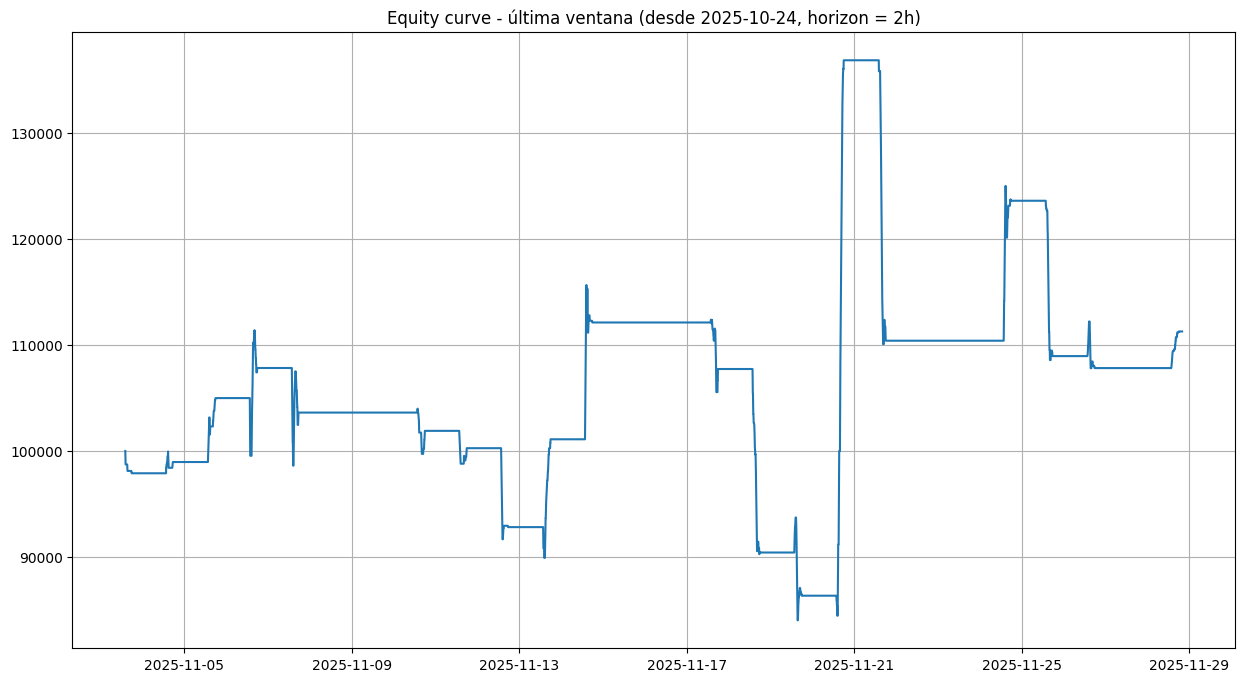

In [93]:
# === 4. Métricas del backtest y curva de capital (ventana reciente) ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 1) Definir ventana de análisis ---
start_date = pd.Timestamp("2025-11-01")
end_date   = pd.Timestamp("2025-12-01")   # o la fecha que quieras ver

results_win = results.loc[start_date:end_date]


# --- 2) Rebasear equity a 1 en el inicio de la ventana ---
equity_series = results_win["equity"] / results_win["equity"].iloc[0]
capital_series = INITIAL_CAPITAL * equity_series

equity_final = equity_series.iloc[-1]
ret_total = equity_final - 1
capital_final = capital_series.iloc[-1]

# --- 3) Recalcular nº de trades en la ventana ---
signal_win = results_win["signal"]

entries = (signal_win.shift(1).fillna(0) == 0) & (signal_win != 0)
n_trades = int(entries.sum())

long_trades  = int((entries & (signal_win > 0)).sum())
short_trades = int((entries & (signal_win < 0)).sum())

pct_largos = long_trades / n_trades if n_trades > 0 else 0
pct_cortos = short_trades / n_trades if n_trades > 0 else 0

# --- 4) Sharpe SOLO en esta ventana ---
# Sharpe por trade
ret_trade = equity_series.pct_change().dropna()
mean_r_trade = ret_trade.mean()
std_r_trade  = ret_trade.std()
sharpe_trade = (mean_r_trade / std_r_trade) * np.sqrt(len(ret_trade))

# Sharpe anualizado (a partir de retornos diarios)
daily_equity = equity_series.resample("1D").last().dropna()
daily_ret = daily_equity.pct_change().dropna()

mean_r_daily = daily_ret.mean()
std_r_daily  = daily_ret.std()
sharpe_annual = (mean_r_daily / std_r_daily) * np.sqrt(252)

# --- 5) Prints ---
print("=== Métricas en términos de equity (base 1) ===")
print(f"Equity inicial: 1.000")
print(f"Equity final:   {equity_final:.3f}")
print(f"Retorno total:  {ret_total:.2%}")
print()
print("=== Métricas en términos de capital (100k iniciales) ===")
print(f"Capital inicial: 100,000 USD")
print(f"Capital final:   {capital_final:,.0f} USD")
print(f"Rentabilidad:    {capital_final / 100000 - 1:.2%}")
print()
print(f"Nº señales (trades): {n_trades}")
print(f"% señales largas:    {pct_largos:.1%}")
print(f"% señales cortas:    {pct_cortos:.1%}")
print()
print(f"Sharpe por trade:           {sharpe_trade:.2f}")
print(f"Sharpe anualizado (diario): {sharpe_annual:.2f}")

# --- 6) Equity curve solo en la ventana ---
plt.figure(figsize=(15, 8))
plt.plot(results_win.index, capital_series)
plt.title("Equity curve - última ventana (desde 2025-10-24, horizon = 2h)")
plt.grid(True)
plt.show()


In [ ]:
# === 5. Registro de operaciones (bloques de posición) ===
import pandas as pd
import numpy as np

HORIZON_HOURS = 2  # prediction horizon en horas

signal_win = results_win["signal"]  # ventana que ya usas arriba

# 1) Entradas: paso de 0 -> ±1
entries = (signal_win != 0) & (signal_win.shift(1).fillna(0) == 0)

# 2) Salidas: paso de ±1 -> 0
exits = (signal_win != 0) & (signal_win.shift(-1).fillna(0) == 0)

entry_idx = results_win.index[entries]
exit_idx  = results_win.index[exits]

if len(entry_idx) != len(exit_idx):
    print("OJO: nº entradas y salidas no coincide:",
          len(entry_idx), len(exit_idx))

# 3) Dirección del trade (según señal en la entrada)
directions = np.where(signal_win.loc[entries] > 0, "LONG", "SHORT")

# 4) Capital antes y después de cada bloque de posición
# capital_series viene rebaseada a 100k en la celda 4
capital_before = capital_series.shift(1).reindex(entry_idx).fillna(INITIAL_CAPITAL).values
capital_after  = capital_series.reindex(exit_idx).values

# 5) Construimos el DataFrame de trades base
trades = pd.DataFrame({
    "entry_time": entry_idx,
    "exit_time": exit_idx,
    "direction": directions,
    "capital_before": capital_before,
    "capital_after": capital_after,
})

trades["profit"] = trades["capital_after"] - trades["capital_before"]
trades["ret_pct"] = trades["profit"] / trades["capital_before"]

# 6) Columnas teóricas (horizon 2h exactas)
trades["theoretical_exit"] = trades["entry_time"] + pd.Timedelta(hours=HORIZON_HOURS)

# capital teórico si cerraras EXACTAMENTE a las 2h
theoretical_cap_after = capital_series.reindex(
    trades["theoretical_exit"], method="ffill"
).values

trades["theoretical_profit"] = theoretical_cap_after - trades["capital_before"]
trades["theoretical_ret_pct"] = trades["theoretical_profit"] / trades["capital_before"]

# Orden y resumen
trades = trades.sort_values("entry_time").reset_index(drop=True)

print(trades.head())
print(f"\nTotal trades (bloques de posición): {len(trades)}")

profit_total = trades["profit"].sum()
print(f"Profit TOTAL registro: {profit_total:.2f} USD")
print(f"Profit según equity:   {capital_final - INITIAL_CAPITAL:.2f} USD")
print(f"Theoretical profit = {trades['theoretical_profit'].sum()}")
trades


           entry_time           exit_time direction  capital_before  \
0 2025-11-03 14:20:00 2025-11-03 16:20:00      LONG   100000.000000   
1 2025-11-03 14:25:00 2025-11-03 16:25:00      LONG   100000.000000   
2 2025-11-03 14:30:00 2025-11-03 16:30:00      LONG    99314.227209   
3 2025-11-03 15:30:00 2025-11-03 17:30:00     SHORT    98727.781263   
4 2025-11-03 15:35:00 2025-11-03 17:35:00     SHORT    98338.447194   

   capital_after      profit   ret_pct  
0   99456.633035 -543.366965 -0.005434  
1   99314.227209 -685.772791 -0.006858  
2   98727.781263 -586.445946 -0.005905  
3   98338.447194 -389.334070 -0.003944  
4   98114.639872 -223.807322 -0.002276  

Total trades (señales): 492
Profit TOTAL registro: 10743.78 USD
Profit según equity:   11287.15 USD


In [117]:
# === 5. Registro de operaciones: 1 señal = 1 trade (horizon 2h) ===
import pandas as pd
import numpy as np

HORIZON_HOURS = 2  # prediction horizon

signal_win = results_win["signal"]

# 1) Cada barra con señal ≠ 0 es un trade
mask = signal_win != 0
trade_idx = results_win.index[mask]
trade_signal = signal_win[mask]

# 2) Capital antes y después del trade, usando la curva real
# capital_series viene de la celda 4 (rebaseada a 100k en el inicio de la ventana)
cap_before = capital_series.shift(1).reindex(trade_idx).fillna(INITIAL_CAPITAL)
cap_after  = capital_series.reindex(trade_idx)

profit = cap_after - cap_before
ret_pct = profit / cap_before

# 3) Construimos el DataFrame de trades
trades = pd.DataFrame({
    "entry_time": trade_idx,
    "exit_time":  trade_idx + pd.Timedelta(hours=HORIZON_HOURS),
    "direction":  np.where(trade_signal > 0, "LONG", "SHORT"),
    "capital_before": cap_before.values,
    "capital_after":  cap_after.values,
    "profit":         profit.values,
    "ret_pct":        ret_pct.values,
})

trades = trades.sort_values("entry_time").reset_index(drop=True)

print(trades.head())
print(f"\nTotal trades (señales): {len(trades)}")

profit_total = trades["profit"].sum()
print(f"Profit TOTAL registro: {profit_total:.2f} USD")
print(f"Profit según equity:   {capital_final - INITIAL_CAPITAL:.2f} USD")


           entry_time           exit_time direction  capital_before  \
0 2025-11-03 14:20:00 2025-11-03 16:20:00      LONG   100000.000000   
1 2025-11-03 14:25:00 2025-11-03 16:25:00      LONG   100000.000000   
2 2025-11-03 14:30:00 2025-11-03 16:30:00      LONG    99314.227209   
3 2025-11-03 15:30:00 2025-11-03 17:30:00     SHORT    98727.781263   
4 2025-11-03 15:35:00 2025-11-03 17:35:00     SHORT    98338.447194   

   capital_after      profit   ret_pct  
0  100000.000000    0.000000  0.000000  
1   99314.227209 -685.772791 -0.006858  
2   98727.781263 -586.445946 -0.005905  
3   98338.447194 -389.334070 -0.003944  
4   98114.639872 -223.807322 -0.002276  

Total trades (señales): 492
Profit TOTAL registro: 11287.15 USD
Profit según equity:   11287.15 USD
